# Outlier-resistant regression

## Vocabulary

This example uses the **normal**, **student's t**, **cauchy**, and **gamma** distributions. A couple notes:

* if you're going to look up just one of these, look up the normal. seriously you need this one.
* student's t shows up more often in frequentist statistics- we'll use it as a variant on the normal that we can tune to have heavier tails
* cauchy is a heavy-tailed distribution; we'll use it here for a broad prior. If you're interested in modeling critical phenomena this is a good tool to have in your belt.
* gamma is another one we'll just use here for a prior. If you're interested in event modeling in continuous time it's worth reading up on (for a Poisson process, it'll be the distribution of waiting times before N events happen). note that there are two ways to parameterize it (wikipedia has both); stan uses one and numpy uses the other.

## The problem

**Note:** This example is modified off from the excellent repository here: https://jrnold.github.io/bugs-examples-in-stan/resistant#ref-Jackman2000a

One of the great things about Bayesian modeling is that it's usually pretty easy (if you're using MCMC) to take a standard model and customize it for your problem. So we're going to take a dataset for which the standard "normally-distributed errors" assumption doesn't quite work, and just swap out a more convenient distribuion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pystan

%matplotlib inline
from IPython.core.pylabtools import figsize

## The data

This dataset was collected by Douglas Grob on incumbency advantage in American congressional elections, 1956-1994 (Jackman 2000). The response variable is the percentage of the vote that went to the Democratic candidate; the covariates include the lagged value and whether a Democrat or Republican was the incumbent. There's also a year indicator that we'll allow to fit as a fixed-effect for each year, since we know there are correlations in how people vote each year (like the Democratic wave electing Obama in 2008 and the midterms in the opposite direction in 2010).

Jackman, Simon. 2000. *“Estimation and Inference Are Missing Data Problems: Unifying Social Science Statistics via Bayesian Simulation.”* Political Analysis 8 (4). [Oxford University Press, Society for Political Methodology]: 307–32. http://www.jstor.org/stable/25791616.

In [2]:
df = pd.read_csv("resistant.csv")
len(df)

5090

In [3]:
df.head()

,y,lagy,prvwinpty,deminc,repinc,year
0,46.304079,56.962606,1,0,0,1
1,54.341075,46.304079,-1,0,1,2
2,58.458012,54.341075,1,1,0,3
3,57.825866,58.458012,1,1,0,4
4,58.467404,69.967915,1,1,0,6


How many unique years?

In [4]:
len(df.year.unique())

20

Let's also take a quick look at the distribution of response variables, broken out by categories in the data. In particular- check out that very-not-normal-looking tail in the middle plot.

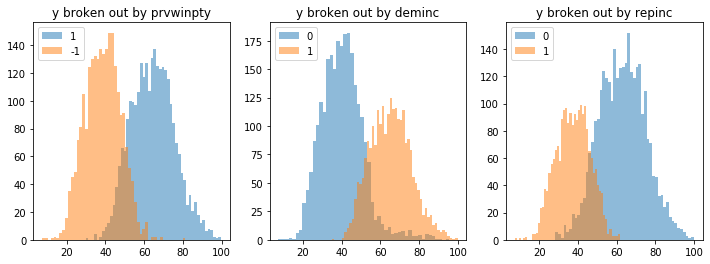

In [11]:
figsize(12,4)
cols = ["prvwinpty", "deminc", "repinc"]
for i in range(3):
    plt.subplot(1,3,i+1)
    col = cols[i]
    for v in df[col].unique():
        plt.hist(df[df[col] == v].y.values, bins=50, alpha=0.5, label=v)
    plt.legend(loc="upper left")
    plt.title("y broken out by %s"%col);

## I'm in a hurry; let's just do normal linear regression like chumps

Let's code up a boring linear regression so we have something to compare against.

I'm also going to split the data up into train and test sets so we can evaluate on out-of-sample data.

In [12]:
# creat dummy variables for each year, and pull out numpy arrays for covariates and dependent variables
X = np.concatenate([df[["lagy", "prvwinpty", "deminc", "repinc"]].values,
              pd.get_dummies(df.year).values], axis=1)
Y = df.y.values
X.shape

(5090, 24)

In [13]:
# random 70/30 train/test split
np.random.seed(1)
test = np.random.choice([False, True], p=[0.7,0.3], size=len(df))
X_test = X[test]
Y_test = Y[test]

X = X[~test,:]
Y = Y[~test]

In [14]:
normal_model_code = """
data {
  int N;
  vector[N] y;
  int K;
  matrix[N, K] X;
  // priors
  real sigma_scale;
  // normal distribution hyperparameters for coefficient priors
  vector[K] beta_loc;
  vector[K] beta_scale;
}
parameters {
  vector[K] beta;
  //real nu;
  real sigma;
  real tau;
  //real intercept;
}
transformed parameters {
  vector[N] mu;
  mu = X * beta;
  //}
}
model{
  // priors for error variance
  sigma ~ cauchy(0., sigma_scale);
  // priors for year intercepts
  //alpha ~ normal(alpha_loc, alpha_scale);
  
  // priors for the regression coefficients
  beta ~ normal(beta_loc, beta_scale);
  // likelihood
  y ~ normal(mu, sigma);
}
"""

In [15]:
%%time
model_norm = pystan.StanModel(model_code=normal_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8e0c682e64a5720815be10a079d111b NOW.


CPU times: user 1.53 s, sys: 58.6 ms, total: 1.58 s
Wall time: 55.5 s


In [16]:
%%time
K = X.shape[1]
data = {"y":Y,
        "X":X,
        "N":X.shape[0],
       "K":K,
       "beta_loc":np.zeros(K),
       "beta_scale":2.5*np.std(Y)*np.ones(K),
       "sigma_scale":5*np.std(Y)}

fit_norm = model_norm.sampling(data=data, iter=1000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 181 ms, sys: 199 ms, total: 380 ms
Wall time: 1min 1s


In [17]:
traces_norm = fit_norm.extract()

Let's do a quick posterior predictive check- what we'll see is that the regression model generally captures the shape of the data, but (not surprisingly) is missing some of the more extreme values:

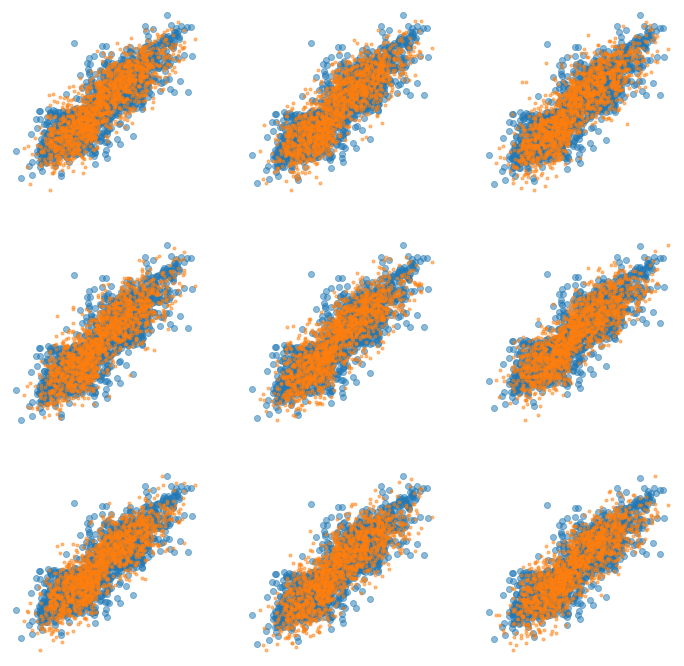

In [18]:
figsize(12,12)
for j in range(9):
    i = np.random.choice(np.arange(traces_norm["beta"].shape[0]))
    beta = traces_norm["beta"][i,:]
    sigma = traces_norm["sigma"][i]
    epsilon = np.random.normal(0, sigma, size=len(Y_test))

    plt.subplot(3,3,j+1)
    plt.plot(Y_test, X_test[:,0], "o", alpha=0.5)
    plt.plot(X_test[:,0], beta.dot(X_test.T)+epsilon, ".", alpha=0.5)
    plt.axis(False);

So depending on what we wanted to do with this regression model, this may or may not be a problem. Let's try fitting a model that can handle those heavy tails.

## Now modify to be more robust against outliers

We'll use Student's T distribution to replace the usual normal likelihood for regression. The T has an extra parameter "degrees of freedom" that lets us tune it- as the DOF approaches infinity, the T distribution becomes the normal; as it gets closer to zero the tails get increasingly fatter. Of course, we don't know the "true" value for the DOF, but since we're good Bayesians we can just put a prior distribution over anything we don't know.

So here's what you should do:

* start with the normal regression code
* add a `real` parameter `nu` to hold the degrees of freedom
* put a `gamma` prior over `nu` (I used `gamma(2, 0.5)`, but hey, you do you)
* replace the `normal` likelihood with a `student_t` likelihood. The `student_t` stan function takes three inputs- degrees of freedom, mean, and scale.

In [19]:
# DELETE THIS FOR THE LAB
t_model_code = """
data {
  int N;
  vector[N] y;
  int K;
  matrix[N, K] X;
  // priors
  real sigma_scale;
  vector[K] beta_loc;
  vector[K] beta_scale;
}
parameters {
  vector[K] beta;
  real nu;
  real sigma;
}
transformed parameters {
  vector[N] mu;
  mu = X * beta;
}
model{
  // priors for error variance
  sigma ~ cauchy(0., sigma_scale);
  
  // priors for the regression coefficients
  beta ~ normal(beta_loc, beta_scale);

  nu ~ gamma(2, 0.5);
  // likelihood
  y ~ student_t(nu, mu, sigma);
}
"""

In [20]:
%%time
model_t = pystan.StanModel(model_code=t_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e3ef4e19a122f72326bec66058830d89 NOW.


CPU times: user 1.52 s, sys: 69.2 ms, total: 1.59 s
Wall time: 56 s


In [21]:
%%time
K = X.shape[1]
data = {"y":Y,
        "X":X,
        "N":X.shape[0],
       "K":K,
       "beta_loc":np.zeros(K),
       "beta_scale":2.5*np.std(Y)*np.ones(K),
       "sigma_scale":5*np.std(Y)}

fit_t = model_t.sampling(data=data, iter=1000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 172 ms, sys: 184 ms, total: 356 ms
Wall time: 1min 5s


In [22]:
traces_t = fit_t.extract()

What value of the degrees-of-freedom parameter did the model think was consistent with the data?

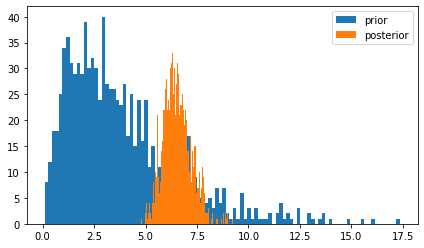

In [23]:
figsize(7,4)
plt.hist(np.random.gamma(2, 1./0.5, size=len(traces_t["nu"])), bins=100, label="prior")
plt.hist(traces_t["nu"], bins=100, label="posterior")
plt.legend(loc="upper right");

### Posterior predictive checks

Let's do a posterior predictive check like we did before for the normal model- look around the edges of the point cloud; this model should generate more-realistic samples that occasionally include an outlier:

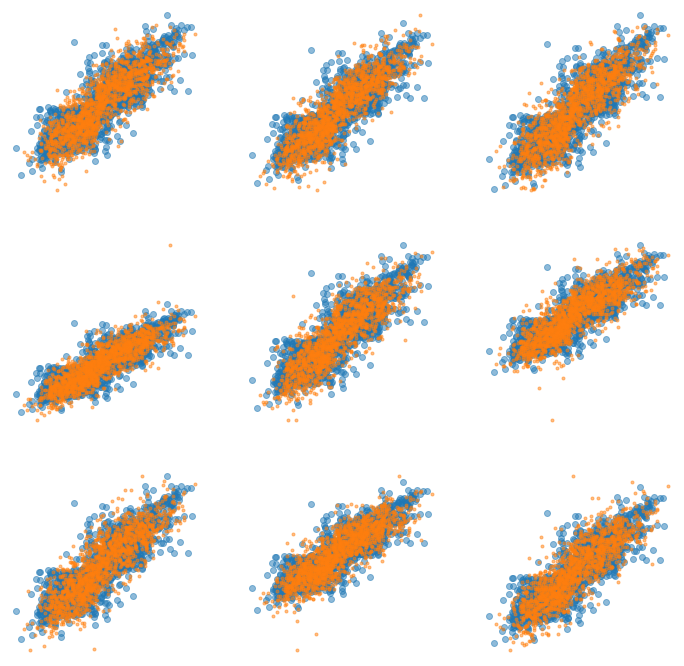

In [24]:
figsize(12,12)
for j in range(9):
    i = np.random.choice(np.arange(traces_t["beta"].shape[0]))
    beta = traces_t["beta"][i,:]
    nu = traces_t["nu"][i]
    sigma = traces_t["sigma"][i]
    epsilon = sigma*np.random.standard_t(nu, size=len(Y_test))

    plt.subplot(3,3,j+1)
    plt.plot(Y_test, X_test[:,0], "o", alpha=0.5)
    plt.plot(X_test[:,0], beta.dot(X_test.T)+epsilon, ".", alpha=0.5)
    plt.axis(False);

Let's do another posterior predictive check- let's compare, for both models, the distribution of **residuals** (the difference between the true value and model prediction) on real data and on generated data.

In [25]:
# NORMAL MODEL
# pick a sample from the posterior
i = np.random.choice(np.arange(traces_norm["beta"].shape[0]))
beta = traces_norm["beta"][i,:]
sigma = traces_norm["sigma"][i]
# compute real-data residuals
resid_norm = Y_test - beta.dot(X_test.T)
# compute synthetic-data residuals
epsilon = np.random.normal(0, sigma, size=len(Y_test))
resid_pp_norm = np.random.normal(0, sigma, size=100*len(Y_test))

In [26]:
# T MODEL
# pick a sample from the posterior
i = np.random.choice(np.arange(traces_t["beta"].shape[0]))
beta = traces_t["beta"][i,:]
nu = traces_t["nu"][i]
sigma = traces_t["sigma"][i]
# compute the synthetic-data residual
resid_t = Y_test - beta.dot(X_test.T)
# compute synthetic-data residuals
resid_pp_t = sigma*np.random.standard_t(nu, size=100*len(Y_test))

Check out the edges of these distributions when we plot a histogram. I found that using a log transformation helped make it more clear.

Given that the two models have basically the same predictive accuracy, why would we even care about the differing shapes of error distributions? Imagine that we wanted to use the model for anomaly detection- the normal model would have an annoyingly high false-positive rate, because it would always flag the outliers in the real data.

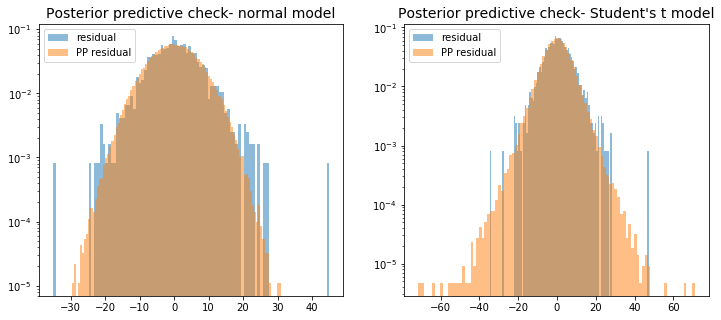

In [27]:
figsize(12,5)
plt.subplot(121)
plt.hist(resid_norm, bins=100, alpha=0.5, density=True, label="residual", log=True)
plt.hist(resid_pp_norm, bins=100, alpha=0.5, density=True, label="PP residual", log=True)
plt.title("Posterior predictive check- normal model", fontsize=14)
plt.legend(loc="upper left")

plt.subplot(122)
plt.hist(resid_t, bins=100, alpha=0.5, density=True, label="residual", log=True)
plt.hist(resid_pp_t, bins=100, alpha=0.5, density=True, label="PP residual", log=True)
plt.title("Posterior predictive check- Student's t model", fontsize=14)
plt.legend(loc="upper left");

## Do the models agree on the coefficients?

What if our goal is inference rather than prediction?

When I ran this, most of the distributions overlapped- so the models *qualitatively* agreed on what the correlates were; if you were concerned with the *quantitative* relationships, however ("how many extra points do we get in next year's election per point of spread in the previous election?"), you'd get different answers:

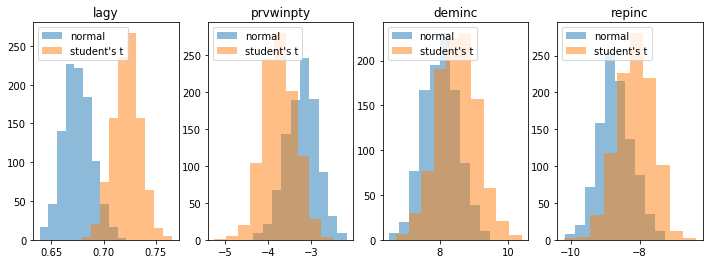

In [28]:
figsize(12,4)
cols = ["lagy", "prvwinpty", "deminc", "repinc"]

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(traces_norm["beta"][:,i], alpha=0.5, label="normal")
    plt.hist(traces_t["beta"][:,i], alpha=0.5, label="student's t")
    plt.title(cols[i])
    plt.legend(loc="upper left");